<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>App</h2>
<h4>IT University of Copenhagen, Spring 2022</h4>
<h4>Group: Nina Sand Horup & Ida Thrane</h4>
</div>

# Input parameters from user

In [253]:
# Input parameters for the user

random_seed = 10

current_position = (55.6935280, 12.5489348)#(some_coordinates)

time_of_day = "mid-day" # Not determined by the user, but a 'hidden' parameter based on the 
# time of the day. Is then translated to one of the two categories: "mid-day" or "afternoon"

preference_activity = ['cultural'] 
# Choose on or more from: ['activity', 'cultural', 'outdoor']

# Import libraries

In [251]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, LineString

pd.options.mode.chained_assignment = None  

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

from pyproj import Geod

%matplotlib inline
ox.__version__

'1.0.1'

In [13]:
# Plotting parameters

current_position_color = 'red'
food_color = 'magenta' # limegreen
chill_color = 'darkorange'
activity_color = 'blue'

In [26]:
geod = Geod(ellps="WGS84")

# Functions

In [143]:
def graph_cols_to_float(G, cols):
    for i, j, key, data in G.edges(keys = True, data = True):
        for col in cols:
            data[col] = float(data[col])
            
            
def subset_gdf_from_coordinate(coordinate, gdf, max_dist):
    current_point = Point(coordinate[1], coordinate[0])
    
    dists = []
    for new_point in gdf.geometry: 
        line_string = LineString([current_point, new_point])
        dist = geod.geometry_length(line_string)
        dists.append(dist)
    
    gdf["dist_to_user"] = dists    
    
    return gdf[gdf["dist_to_user"] < max_dist]

def subset_graph_from_coordinate(coordinate, G, max_dist):
    current_point = Point(coordinate[1], coordinate[0])
    
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)
    edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
    dists = []
    for new_point in nodes.geometry: 
        line_string = LineString([current_point, new_point])
        dist = geod.geometry_length(line_string)
        dists.append(dist)
    
        
    nodes["dist_to_user"] = dists    
    nodes_subset_df = nodes[nodes["dist_to_user"] < max_dist]
    nodes_subset = list(nodes_subset_df.index)
    
    edges_subset_df = edges.query('u in @nodes_subset and v in @nodes_subset')
    
    new_G = ox.utils_graph.graph_from_gdfs(nodes_subset_df, edges_subset_df)
    return new_G


def get_nearest_node(input_coordinate, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)

    distance = nodes.apply(lambda x: np.sqrt((x.y - input_coordinate[0])**2 + (x.x - input_coordinate[1])**2) , axis = 1)
    output = distance.idxmin()
    return output


# Function to calculate nearest distance to either the big water areas or the big park areas:

def dist_to_nearest_nature(coords, water, parks):
    
    #coords = list(gdf["coordinates"])
    polygons_water = water['geometry']
    polygons_water.reset_index(inplace = True, drop = True)
    
    polygons_parks = parks['geometry']
    polygons_parks.reset_index(inplace = True, drop = True)

    
    # Lists for saving results
    min_distances_to_nature = []
    nature_with_min_dist = []
    nature_type_nearest = []
    
    # Find distance to nearest polygon
    for coord in coords:
        coord = Point(coord[1], coord[0])
        # Water
        dist_to_waters = []
        for poly in polygons_water:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_waters.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_waters.append(distance)
        dist_to_nearest_water = min(dist_to_waters)
        nearest_water = polygons_water[np.argmin(dist_to_waters)]
        
        # Park areas
        dist_to_parks = []
        
        for poly in polygons_parks:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_parks.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_parks.append(distance)
        dist_to_nearest_park = min(dist_to_parks)
        nearest_park = polygons_parks[np.argmin(dist_to_parks)]
        
        # Both
        dist_to_nearest_nature = min(dist_to_nearest_water, dist_to_nearest_park)
        min_distances_to_nature.append(dist_to_nearest_nature)
        
        if dist_to_nearest_water < dist_to_nearest_park:
            nature_with_min_dist.append(nearest_water)
            nature_type_nearest.append("water")
        else:
            nature_with_min_dist.append(nearest_park)
            nature_type_nearest.append("park")
    
    return min_distances_to_nature, nature_with_min_dist, nature_type_nearest
  

# Import preprocessed data from 'database'

Import graph

In [15]:
## Import graph data from folder

G = ox.io.load_graphml("./data/graphs/G_copenhagen_preprocessed")
cols_to_float = ['use_cost', 'speed_cost', 'park_gain', 'water_gain', 'total_cost']
graph_cols_to_float(G, cols_to_float)

Import destinations

In [52]:
food=gpd.read_file("data/geometries/food_destinations.json")
food=food.set_index("id")

chill= gpd.read_file("data/geometries/chill_destinations.json")
chill=chill.set_index("id")

activity= gpd.read_file("data/geometries/activity_destinations.json")
activity=activity.set_index("id")


There are  396 food places in the area


## Get subset of destinations with 2000 m. of the user and which fits the user input

I.e. the filters such as 'time-of-day' and 'preference-activity'

In [254]:
max_dist_G = 2000
max_dist_destinations = 1500

# Getting subset of G

G_subset = subset_graph_from_coordinate(current_position, G, max_dist_G)


# Implementing time-of-day filter

if time_of_day == "mid-day":
    food_subset_0 = food[(food.time == "all_day") | (food.time == "daytime")]
    chill_subset_0 = chill[(chill.time == "all_day") | (chill.time == "daytime")]
    activity_subset_0 = activity[(activity.time == "all_day") | (activity.time == "daytime")]

if time_of_day == "afternoon":
    food_subset_0 = food[(food.time == "all_day") | (food.time == "nighttime")]
    chill_subset_0 = chill[(chill.time == "all_day") | (chill.time == "nighttime")]
    activity_subset_0 = activity[(activity.time == "all_day") | (activity.time == "nighttime")]

# Implementing the activity preference filter
activity_subset_1 = activity_subset_0[activity_subset_0.category.isin(preference_activity)]

# Getting the destinations within 2000 m. of the user

food_subset = subset_gdf_from_coordinate(current_position, food_subset_0, max_dist_destinations)
print("There are ", len(food_subset), "food places in the area")

chill_subset = subset_gdf_from_coordinate(current_position, chill_subset_0, max_dist_destinations)
print("There are ", len(chill_subset), "relaxing places in the area")

activity_subset = subset_gdf_from_coordinate(current_position, activity_subset_1, max_dist_destinations)
print("There are ", len(activity_subset), "activities in the area")


There are  220 food places in the area
There are  12 relaxing places in the area
There are  34 activities in the area


## Get the 10 food places, relaxing places and activities near the user

In [255]:
# We first convert the coordinates of our current position into a node:

current_node = get_nearest_node(current_position, G_subset)

# Get the indexes of the 10 food places closest to nature: 

indexes_food = np.argsort(food_subset.dist_to_nature)[:10]
food_node_ids_nature = np.array(food_subset["nearest node"])[indexes_food] 
food_node_ids_nature_and_current_position = np.append(food_node_ids_nature, current_node)


# Get the indexes of the 10 relaxing places closest to nature: 

indexes_chill = np.argsort(chill_subset.dist_to_nature)[:10]
chill_node_ids_nature = np.array(chill_subset["nearest node"])[indexes_chill] 
chill_node_ids_nature_and_current_position = np.append(chill_node_ids_nature, current_node)


# Get the indexes of the 10 activities closest to nature: 

indexes_activity = np.argsort(activity_subset.dist_to_nature)[:10]
activity_node_ids_nature = np.array(activity_subset["nearest node"])[indexes_activity] 
activity_node_ids_nature_and_current_position = np.append(activity_node_ids_nature, current_node)




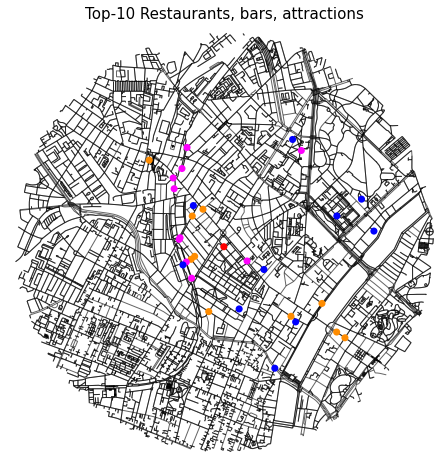

In [256]:

# create node weights 
node_weights = [50 if (node in food_node_ids_nature_and_current_position) or (node in chill_node_ids_nature_and_current_position) or (node in activity_node_ids_nature_and_current_position) else 0 for node in G_subset.nodes]

node_colours = [current_position_color if node == current_node else food_color if node in food_node_ids_nature else chill_color if node in chill_node_ids_nature else activity_color if node in activity_node_ids_nature else 'white' for node in G_subset.nodes]


# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(G_subset, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Top-10 Restaurants, bars, attractions", fontsize = 15)

#plt.savefig('./plots/Subset/restaurants_bars_attractions.png')

plt.show()


## Choosing good combinations of destinations for routing

The order of destinations depend on the time-of-day, i.e. the type of date we want to create. In the evening, it will make most sense to do the activity first (before it gets dark), and then go to a place to relax (probably a bar) to lastly end up at a restaurant. If the date is earlier in the day, we start of with a snack, then go to the activity, and lastly goes to get food. 

In [265]:
if time_of_day == "mid-day":
    a, a_df = chill_node_ids_nature, chill 
    b, b_df = activity_node_ids_nature, activity
    c, c_df = food_node_ids_nature, food

if time_of_day == "afternoon":
    a, a_df = activity_node_ids_nature, activity
    b, b_df = chill_node_ids_nature, chill
    c, c_df = food_node_ids_nature, food

a_b_c = np.append(a, np.append(b, c))

#### Keep track of possible permutations

In [266]:
all_permutations = []

for i in range(len(a)):
    for j in range(len(b)):
        for k in range(len(c)):
            #print(i,j,k)

            all_permutations.append((i,j,k))

print(len(all_permutations))


1000


#### Remove routes where points are too close or too far

Stop if we get to less than 20 routes

In [267]:
irrelevant_permutations = []
relevant_permutations = []

for i in range(len(a)):
    #print("i", i)
    
    node1 = a[i]
    point1 = Point(G_subset.nodes[node1]["y"], G_subset.nodes[node1]["x"])
    
    for j in range(len(b)):
        #print("j", j)
        
        node2 = b[j]
        point2 = Point(G_subset.nodes[node2]["y"], G_subset.nodes[node2]["x"])
        
        line_string12 = LineString([point1, point2])
        dist12 = geod.geometry_length(line_string12)
        #print(dist12)
        for k in range(len(c)):
            #print("k", k)
            #print(i,j,k)
            
            node3 = c[k]
            point3 = Point(G_subset.nodes[node3]["y"], G_subset.nodes[node3]["x"])
            
            line_string13 = LineString([point1, point3])
            dist13 = geod.geometry_length(line_string13)
            line_string23 = LineString([point2, point3])
            dist23 = geod.geometry_length(line_string23)
            
            if len(all_permutations) - len(irrelevant_permutations) > 15:
                if (dist12 > 300) and (dist12 < 1500) and (dist13 > 300) and (dist23 > 300) and (dist23 < 1500):
                    relevant_permutations.append([node1,node2,node3])
                else: 
                    irrelevant_permutations.append([node1,node2,node3])
            else:
                relevant_permutations.append([node1,node2,node3])

if len(relevant_permutations) < 16:
    final_routes = relevant_permutations                

#### Get destinations where nearest nature type is different

Only do this step if we have more than 15 routes

Steps: 
- only include routes which are close to both water and park
- if the upper condition renders less than 15 routes, we pick a random subset of other routes untill we have 15 candidates. 

In [268]:
np.random.seed(random_seed)
if len(relevant_permutations) > 15:
    
    # Get routes where nature type differs
    nature_type_permutations = []
    non_nature_type_permutations = []
    
    for i in relevant_permutations:
        a_r = i[0]
        a_nature_type = a_df.nearest_nature_type[a_df["nearest node"] == a_r][0]

        b_r = i[1]
        b_nature_type = b_df.nearest_nature_type[b_df["nearest node"] == b_r][0]

        c_r = i[2]
        c_nature_type = c_df.nearest_nature_type[c_df["nearest node"] == c_r][0]

        list_of_nature = [a_nature_type, b_nature_type, c_nature_type]

        if len(set(list_of_nature)) > 1: 
            nature_type_permutations.append(i)
        else: 
            non_nature_type_permutations.append(i)

    print(len(nature_type_permutations))

# Take a random subset of 15 if we have too many candidates

if len(nature_type_permutations) > 15:

    final_subset_num = np.random.choice(np.arange(0,len(nature_type_permutations), 1), size = 15)
    
    final_routes = np.asarray(nature_type_permutations)[final_subset_num]
    
    print(len(final_routes))

# Add a random subset from the previous filter if we have less than 15 candidates

if len(relevant_permutations) > 15 and len(nature_type_permutations) < 15:
    routes_to_add = 15 - len(nature_type_permutations)
    
    random_subset = np.random.choice(np.arange(0,len(non_nature_type_permutations), 1), size = routes_to_add)
    
    random_routes = np.asarray(non_nature_type_permutations)[random_subset]

    final_routes = np.concatenate((nature_type_permutations, random_routes), axis=0)
    
    print(len(final_routes))

44
15


Add a random subset if we have less than 15 routes: 

# Making the route


In [269]:
# Get three routes out of the 15 (change random seed to get three new proposals)
np.random.seed(random_seed)

# Get random route: 

route1_num = np.random.choice(np.arange(0,len(final_routes), 1), size = 1)
route1 = np.asarray(final_routes)[route1_num][0]

print(route1)

# Get subset of routes where as few as possible of the destinations are the same as route1: 
unique_items = []

for route2 in final_routes:
    route12 = np.append(route1, route2)
    unique_items.append(len(set(route12)))

indices_best = np.where(unique_items == np.max(unique_items))
route2_num = np.random.choice(indices_best[0])
route2 = np.asarray(final_routes)[route2_num]
print(route2)

# Get subset of routes where as few as possible of the destinations are the same as route1 and route2: 
unique_items_2 = []

for route3 in final_routes:
    route123 = np.append(route1, np.append(route2, route3))
    unique_items_2.append(len(set(route123)))

indices_best_2 = np.where(unique_items_2 == np.max(unique_items_2))
route3_num = np.random.choice(indices_best_2[0])
route3 = np.asarray(final_routes)[route3_num]
print(route3)

final_routes_subset = (route1, route2, route3)


route_N = 0 # 0, 1, 2
orig_id = current_node
id_0 = final_routes_subset[route_N][0] #afternoon: activity, mid-day: chill
id_1 = final_routes_subset[route_N][1] #afternoon: chill, mid-day: activity
id_2 = final_routes_subset[route_N][2] #food

[ 298466822 5842178242  478634644]
[7726683 7235708 8233793]
[   7846717 6878483616  478634644]


### Information on this route: 

Here we print which attraction, bar and restaurant the route visits.



In [270]:
if time_of_day == "mid-day":
    chill_visited = chill[chill["nearest node"] == id_0]
    activity_visited = activity[activity["nearest node"] == id_1]
    food_visited = food[food["nearest node"] == id_2]

if time_of_day == "afternoon":
    activity_visited = activity[activity["nearest node"] == id_0]
    chill_visited = chill[chill["nearest node"] == id_1]
    food_visited = food[food["nearest node"] == id_2]


In [274]:
activity_name = activity_visited.name.values[0]
activity_type = None
if activity_visited.amenity.values[0] != None:
    activity_type = activity_visited.amenity.values[0]
if activity_visited.leisure.values[0] != None:
    activity_type = activity_visited.leisure.values[0]
if activity_visited.tourism.values[0] != None:
    activity_type = activity_visited.tourism.values[0]

if time_of_day == "mid-day":    
    if activity_type and activity_name:
        activity_string = f"Then it's time for some {activity_visited.category.values[0]}-time! Let's visit the {activity_type} '{activity_name}'"
    if activity_type and not activity_name:
        activity_string = f"Then it's time for some {activity_visited.category.values[0]}-time! Let's visit a {activity_type}"
    if activity_name and not activity_type:
        activity_string = f"Then it's time for some {activity_visited.category.values[0]}-time! Let's visit {activity_name}"
    if (activity_name == None) and (activity_type == None): 
        activity_string = f"Then it's time for some fun. The second destination is will ensure some {activity_visited.category.values[0]}-time!"

if time_of_day == "afternoon":    
    if activity_type and activity_name:
        activity_string = f"Let's have some {activity_visited.category.values[0]}-time! First visit the {activity_type} '{activity_name}'"
    if activity_type and not activity_name:
        activity_string = f"Let's have some {activity_visited.category.values[0]}-time! First visit a {activity_type}"
    if activity_name and not activity_type:
        activity_string = f"Let's have some {activity_visited.category.values[0]}-time! First visit {activity_name}"
    if (activity_name == None) and (activity_type == None): 
        activity_string = f"Let's first have some fun! The first destination is will ensure some {activity_visited.category.values[0]}-time!"

if time_of_day == "mid-day":
    chill_string = f"First off to '{chill_visited.name.values[0]}' to chill for a bit."
if time_of_day == "afternoon":
    chill_string = f"Then you go to '{chill_visited.name.values[0]}' and relax for a bit."

food_string = f"We end the trip at '{food_visited.name.values[0]}' for some great food."

if time_of_day == "mid-day":
    print(chill_string)
    print(activity_string)
    print(food_string)

if time_of_day == "afternoon":
    print(activity_string)
    print(chill_string)
    print(food_string)


First off to 'Isoteket' to chill for a bit.
Then it's time for some cultural-time! Let's visit the arts_centre 'LiteraturHaus'
We end the trip at 'HCØ Kantine' for some great food.


# Calculating the route (length only)

The total route is 3407 meters.


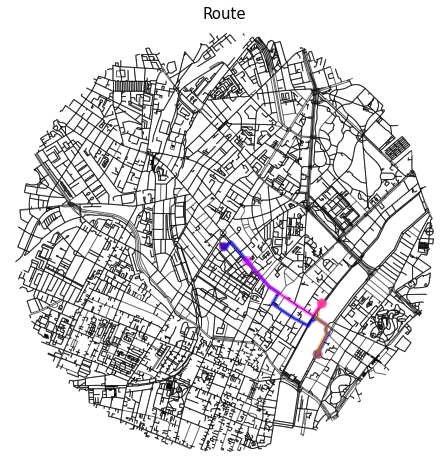

In [181]:
route1 = ox.shortest_path(G_subset, orig_id, id_0, weight="length")
route2 = ox.shortest_path(G_subset, id_0, id_1, weight="length")
route3 = ox.shortest_path(G_subset, id_1, id_2, weight="length")

routes = [route1, route2, route3]

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route3, "length")))

print("The total route is", route1_length + route2_length + route3_length, "meters.")

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
# create node weights 
node_weights = [50 if (node == orig_id) or (node == id_0) or (node == id_1) or (node == id_1) else 0 for node in G_subset.nodes]

node_colours = [current_position_color if node == current_node else activity_color if node == id_0 else chill_color if node == id_1 else food_color if node == id_2 else 'white' for node in G_subset.nodes]

fig, ax = ox.plot_graph_routes(G_subset, routes, route_colors=[attraction_color, bar_color, restaurant_color], node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Route", fontsize = 15)

plt.show()


# Making a new route with the new attributes

The total route is 4412 meters.


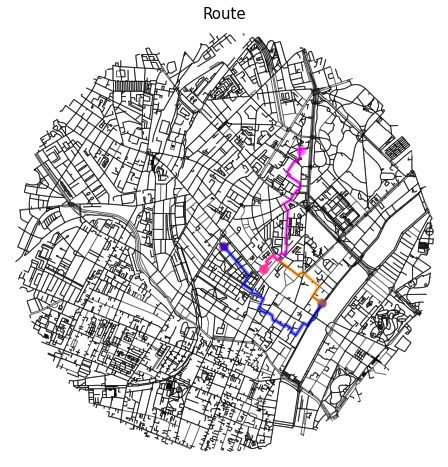

In [275]:
route1 = ox.shortest_path(G_subset, orig_id, id_0, weight="total_cost")
route2 = ox.shortest_path(G_subset, id_0, id_1, weight="total_cost")
route3 = ox.shortest_path(G_subset, id_1, id_2, weight="total_cost")

routes = [route1, route2, route3]

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_subset, route3, "length")))

print("The total route is", route1_length + route2_length + route3_length, "meters.")

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
# create node weights 
node_weights = [50 if (node == orig_id) or (node == id_0) or (node == id_1) or (node == id_1) else 0 for node in G_subset.nodes]

node_colours = [current_position_color if node == current_node else activity_color if node == id_0 else chill_color if node == id_1 else food_color if node == id_2 else 'white' for node in G_subset.nodes]

fig, ax = ox.plot_graph_routes(G_subset, routes, route_colors=[attraction_color, bar_color, restaurant_color], node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Route", fontsize = 15)

plt.show()
